# Alphalens and Pyfolio integration

Alphalens can simulate the performance of a portfolio where the factor values are use to weight stocks. Once the portfolio is built, it can be analyzed by Pyfolio. For details on how this portfolio is built see:
- alphalens.performance.factor_returns
- alphalens.performance.cumulative_returns 
- alphalens.performance.create_pyfolio_input

In [40]:
%pylab inline --no-import-all
import alphalens
import pyfolio
import pandas as pd
import numpy as np
import datetime

Populating the interactive namespace from numpy and matplotlib


First load some stocks data

In [41]:
tickers = [ 'ACN', 'ATVI', 'ADBE', 'AMD', 'AKAM', 'ADS', 'GOOGL', 'GOOG', 'APH', 'ADI', 'ANSS', 'AAPL',
'AVGO', 'CA', 'CDNS', 'CSCO', 'CTXS', 'CTSH', 'GLW', 'CSRA', 'DXC', 'EBAY', 'EA', 'FFIV', 'FB',
'FLIR', 'IT', 'GPN', 'HRS', 'HPE', 'HPQ', 'INTC', 'IBM', 'INTU', 'JNPR', 'KLAC', 'LRCX', 'MA', 'MCHP',
'MSFT', 'MSI', 'NTAP', 'NFLX', 'NVDA', 'ORCL', 'PAYX', 'PYPL', 'QRVO', 'QCOM', 'RHT', 'CRM', 'STX',
'AMG', 'AFL', 'ALL', 'AXP', 'AIG', 'AMP', 'AON', 'AJG', 'AIZ', 'BAC', 'BK', 'BBT', 'BRK.B', 'BLK', 'HRB',
'BHF', 'COF', 'CBOE', 'SCHW', 'CB', 'CINF', 'C', 'CFG', 'CME', 'CMA', 'DFS', 'ETFC', 'RE', 'FITB', 'BEN',
'GS', 'HIG', 'HBAN', 'ICE', 'IVZ', 'JPM', 'KEY', 'LUK', 'LNC', 'L', 'MTB', 'MMC', 'MET', 'MCO', 'MS',
'NDAQ', 'NAVI', 'NTRS', 'PBCT', 'PNC', 'PFG', 'PGR', 'PRU', 'RJF', 'RF', 'SPGI', 'STT', 'STI', 'SYF', 'TROW',
'ABT', 'ABBV', 'AET', 'A', 'ALXN', 'ALGN', 'AGN', 'ABC', 'AMGN', 'ANTM', 'BCR', 'BAX', 'BDX', 'BIIB', 'BSX',
'BMY', 'CAH', 'CELG', 'CNC', 'CERN', 'CI', 'COO', 'DHR', 'DVA', 'XRAY', 'EW', 'EVHC', 'ESRX', 'GILD', 'HCA',
'HSIC', 'HOLX', 'HUM', 'IDXX', 'ILMN', 'INCY', 'ISRG', 'IQV', 'JNJ', 'LH', 'LLY', 'MCK', 'MDT', 'MRK', 'MTD',
'MYL', 'PDCO', 'PKI', 'PRGO', 'PFE', 'DGX', 'REGN', 'RMD', 'SYK', 'TMO', 'UNH', 'UHS', 'VAR', 'VRTX', 'WAT',
'MMM', 'AYI', 'ALK', 'ALLE', 'AAL', 'AME', 'AOS', 'ARNC', 'BA', 'CHRW', 'CAT', 'CTAS', 'CSX', 'CMI', 'DE',
'DAL', 'DOV', 'ETN', 'EMR', 'EFX', 'EXPD', 'FAST', 'FDX', 'FLS', 'FLR', 'FTV', 'FBHS', 'GD', 'GE', 'GWW',
'HON', 'INFO', 'ITW', 'IR', 'JEC', 'JBHT', 'JCI', 'KSU', 'LLL', 'LMT', 'MAS', 'NLSN', 'NSC', 'NOC', 'PCAR',
'PH', 'PNR', 'PWR', 'RTN', 'RSG', 'RHI', 'ROK', 'COL', 'ROP', 'LUV', 'SRCL', 'TXT', 'TDG', 'UNP', 'UAL',
'AES', 'LNT', 'AEE', 'AEP', 'AWK', 'CNP', 'CMS', 'ED', 'D', 'DTE', 'DUK', 'EIX', 'ETR', 'ES', 'EXC']

In [42]:
# tickers = ['AAPL','HON',"PH"]
import pandas_datareader.data as web
pan = web.DataReader(tickers, "yahoo", datetime.datetime(2015, 1, 1),  datetime.datetime(2017, 1, 1))

In [43]:
pan = pan.transpose(2,1,0)

We'll compute a simple mean reversion factor looking at recent stocks performance: stocks that performed well in the last 5 days will have high rank and vice versa.

In [44]:
factor = pan.loc[:,:,'Open']
factor = -factor.pct_change(5)

factor = factor.stack()
factor.index = factor.index.set_names(['date', 'asset'])

The pricing data passed to alphalens should contain the entry price for the assets so it must reflect the next available price after a factor value was observed at a given timestamp. Those prices must not be used in the calculation of the factor values for that time. Always double check to ensure you are not introducing lookahead bias to your study.

The pricing data must also contain the exit price for the assets, for period 1 the price at the next timestamp will be used, for period 2 the price after 2 timestats will be used and so on.

There are no restrinctions/assumptions on the time frequencies a factor should be computed at and neither on the specific time a factor should be traded (trading at the open vs trading at the close vs intraday trading), it is only required that factor and price DataFrames are properly aligned given the rules above.

In our example, before the trading starts every day, we observe yesterday factor values. The price we pass to alphalens is the next available price after that factor observation: the daily open price that will be used as assets entry price. Also, we are not adding additional prices so the assets exit price will be the following days open prices (how many days depends on 'periods' argument). The retuns computed by Alphalens will therefore based on assets open prices.

In [45]:
pricing = pan.loc[:,:,'Open'].iloc[1:]
pricing.head()

,A,AAL,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,ADS,...,TROW,TXT,UAL,UHS,UNH,UNP,VAR,VRTX,WAT,XRAY
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-05,40.320000,54.369999,108.290001,65.500000,90.070000,44.799999,88.040001,72.209999,55.400002,286.579987,...,85.050003,41.820000,66.870003,110.419998,100.300003,118.309998,76.036057,122.269997,113.620003,51.939999
2015-01-06,39.810001,54.270000,106.540001,65.620003,90.139999,44.990002,87.500000,71.949997,54.730000,282.000000,...,84.389999,41.520000,66.629997,108.529999,99.830002,114.279999,75.176697,121.309998,112.949997,51.590000
2015-01-07,39.520000,53.380001,107.199997,64.570000,90.980003,44.730000,87.160004,70.769997,53.490002,280.589996,...,82.470001,41.639999,64.959999,110.300003,98.959999,113.160004,75.036392,118.820000,113.470001,51.369999
2015-01-08,40.240002,53.480000,109.230003,68.160004,91.739998,45.189999,89.000000,71.400002,54.389999,284.570007,...,84.129997,41.860001,65.699997,112.650002,101.570000,114.000000,76.588509,122.000000,117.110001,52.540001
2015-01-09,41.000000,53.669998,112.669998,66.690002,92.440002,45.750000,89.949997,72.889999,54.990002,287.929993,...,84.570000,43.419998,66.760002,113.330002,104.419998,117.080002,77.956474,123.750000,118.139999,53.750000


# Prepare data and run Alphalens

Pyfolio wants timezone set to UTC otherwise it refuses to work

In [46]:
pricing.index = pricing.index.tz_localize('UTC')

In [47]:
factor = factor.unstack()
factor.index = factor.index.tz_localize('UTC')
factor = factor.stack()

In [48]:
factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor,
                                                                   pricing,
                                                                   periods=(1, 3, 5),
                                                                   quantiles=5,
                                                                   bins=None)
factor_data.head()

Dropped 1.0% entries from factor data: 1.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


1D        3D        5D    factor  \
date                      asset                                           
2015-01-09 00:00:00+00:00 A     -0.009512 -0.048049 -0.077317  0.004371   
                          AAL   -0.048630 -0.079374 -0.079933  0.011238   
                          AAPL  -0.000621 -0.032218 -0.050058 -0.011491   
                          ABBV  -0.005248 -0.061029 -0.056080 -0.019101   
                          ABC    0.014388 -0.011034 -0.014063 -0.020196   

                                 factor_quantile  
date                      asset                   
2015-01-09 00:00:00+00:00 A                    3  
                          AAL                  3  
                          AAPL                 2  
                          ABBV                 2  
                          ABC                  1

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-63.109756,0.075805,-0.044881,0.410116,24125,20.159269
2,-0.113547,0.097449,-0.013897,0.020908,23834,19.916104
3,-0.080349,0.112009,-0.001697,0.019834,23874,19.949529
4,-0.046988,0.127907,0.010337,0.020233,23828,19.911090
5,-0.028090,0.846154,0.036670,0.034123,24011,20.064008


Returns Analysis


,1D,3D,5D
Ann. alpha,0.421,0.168,0.074
beta,0.142,-0.042,0.075
Mean Period Wise Return Top Quantile (bps),3.946,2.010,1.978
Mean Period Wise Return Bottom Quantile (bps),-2.175,-1.476,-1.362
Mean Period Wise Spread (bps),6.148,3.480,3.335


Information Analysis


,1D,3D,5D
IC Mean,0.013,0.009,0.016
IC Std.,0.173,0.168,0.169
Risk-Adjusted IC,0.077,0.056,0.093
t-stat(IC),1.718,1.252,2.064
p-value(IC),0.086,0.211,0.040
IC Skew,0.041,0.195,0.094
IC Kurtosis,0.334,0.350,0.415


Turnover Analysis


,1D,3D,5D
Quantile 1 Mean Turnover,0.346,0.602,0.790
Quantile 2 Mean Turnover,0.605,0.744,0.800
Quantile 3 Mean Turnover,0.649,0.763,0.785
Quantile 4 Mean Turnover,0.603,0.745,0.798
Quantile 5 Mean Turnover,0.350,0.597,0.781


,1D,3D,5D
Mean Factor Rank Autocorrelation,0.753,0.36,-0.015


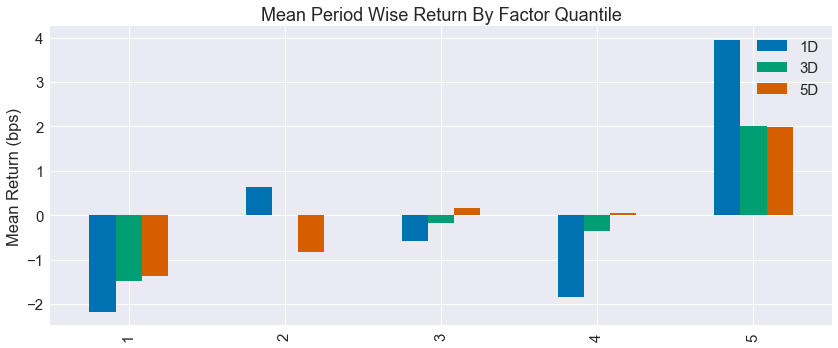

In [49]:
alphalens.tears.create_summary_tear_sheet(factor_data)

# Prepare data for Pyfolio

We can see in Alphalens analysis that quantiles 1 and 5 are the most predictive so we'll build a portfolio data using only those quantiles.

In [50]:
pf_returns, pf_positions, pf_benchmark = \
    alphalens.performance.create_pyfolio_input(factor_data,
                                               period='1D',
                                               capital=100000,
                                               long_short=True,
                                               group_neutral=False,
                                               equal_weight=True,
                                               quantiles=[1,5],
                                               groups=None,
                                               benchmark_period='1D')

/Users/bwuebben/anaconda3/envs/py27/lib/python2.7/site-packages/pandas/tseries/index.py:814: PerformanceWarning: Non-vectorized DateOffset being applied to Series or DatetimeIndex


Now that we have prepared the data we can run Pyfolio functions

Entire data start date: 2015-01-12
Entire data end date: 2016-12-23
Backtest months: 24


,Backtest
Annual return,7.6%
Cumulative returns,16.0%
Annual volatility,6.2%
Sharpe ratio,1.21
Calmar ratio,1.08
Stability,0.70
Max drawdown,-7.0%
Omega ratio,1.26
Sortino ratio,1.98
Skew,1.49


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.03,2016-03-31,2016-11-15,NaT,NaN
1,3.21,2015-02-05,2015-03-06,2015-04-08,45
2,3.17,2016-01-05,2016-01-20,2016-02-15,30
3,2.53,2015-09-04,2015-09-29,2015-10-16,31
4,1.76,2015-07-06,2015-08-24,2015-08-25,37


ImportError: cannot import name PY36

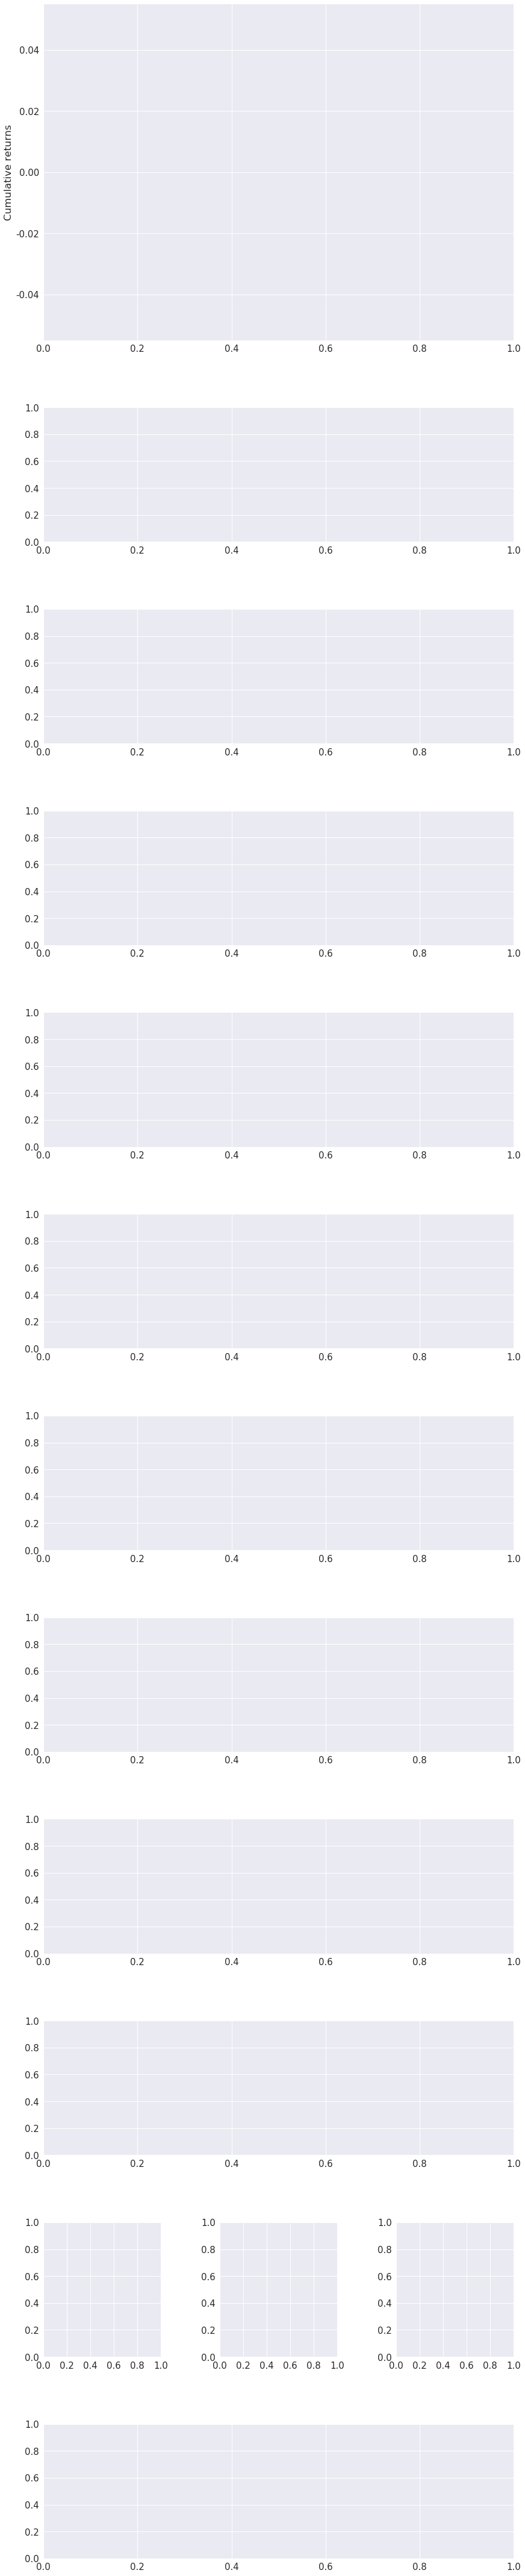

In [51]:
pyfolio.tears.create_full_tear_sheet(pf_returns,
                                     positions=pf_positions,
                                     benchmark_rets=pf_benchmark)

## Analyzing subsets of data

Sometimes it might be useful to analyze subets of your factor data, for example it could be interesting to see the comparison of your factor in different days of the week. Below we'll see how to select and analyze factor data corresponding to Mondays, the positions will be held the for a period of 5 days

In [13]:
monday_factor_data = factor_data[ factor_data.index.get_level_values('date').weekday == 0 ]

In [14]:
pf_returns, pf_positions, pf_benchmark = \
    alphalens.performance.create_pyfolio_input(monday_factor_data,
                                               period='5D',
                                               capital=100000,
                                               long_short=True,
                                               group_neutral=False,
                                               equal_weight=True,
                                               quantiles=[1,5],
                                               groups=None,
                                               benchmark_period='1D')

/home/lucasca/dev/alphalens/empyrical/stats.py:821: RuntimeWarning: Mean of empty slice
  return nanmean(alpha_series) * ann_factor


Start date,2015-01-19
End date,2016-12-26
Total months,4
,Backtest
Annual return,15.5%
Cumulative returns,6.0%
Annual volatility,13.5%
Sharpe ratio,1.13
Calmar ratio,1.61
Stability,0.20
Max drawdown,-9.6%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.60,2015-12-28,2016-09-05,NaT,NaN
1,3.17,2015-02-09,2015-04-06,2015-06-22,96
2,2.34,2015-06-22,2015-08-24,2015-08-31,51
3,0.36,2015-10-05,2015-10-12,2015-10-19,11
4,0.26,2015-08-31,2015-09-07,2015-09-28,21


/home/lucasca/.local/lib/python3.5/site-packages/matplotlib/axes/_base.py:3285: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  'bottom=%s, top=%s') % (bottom, top))


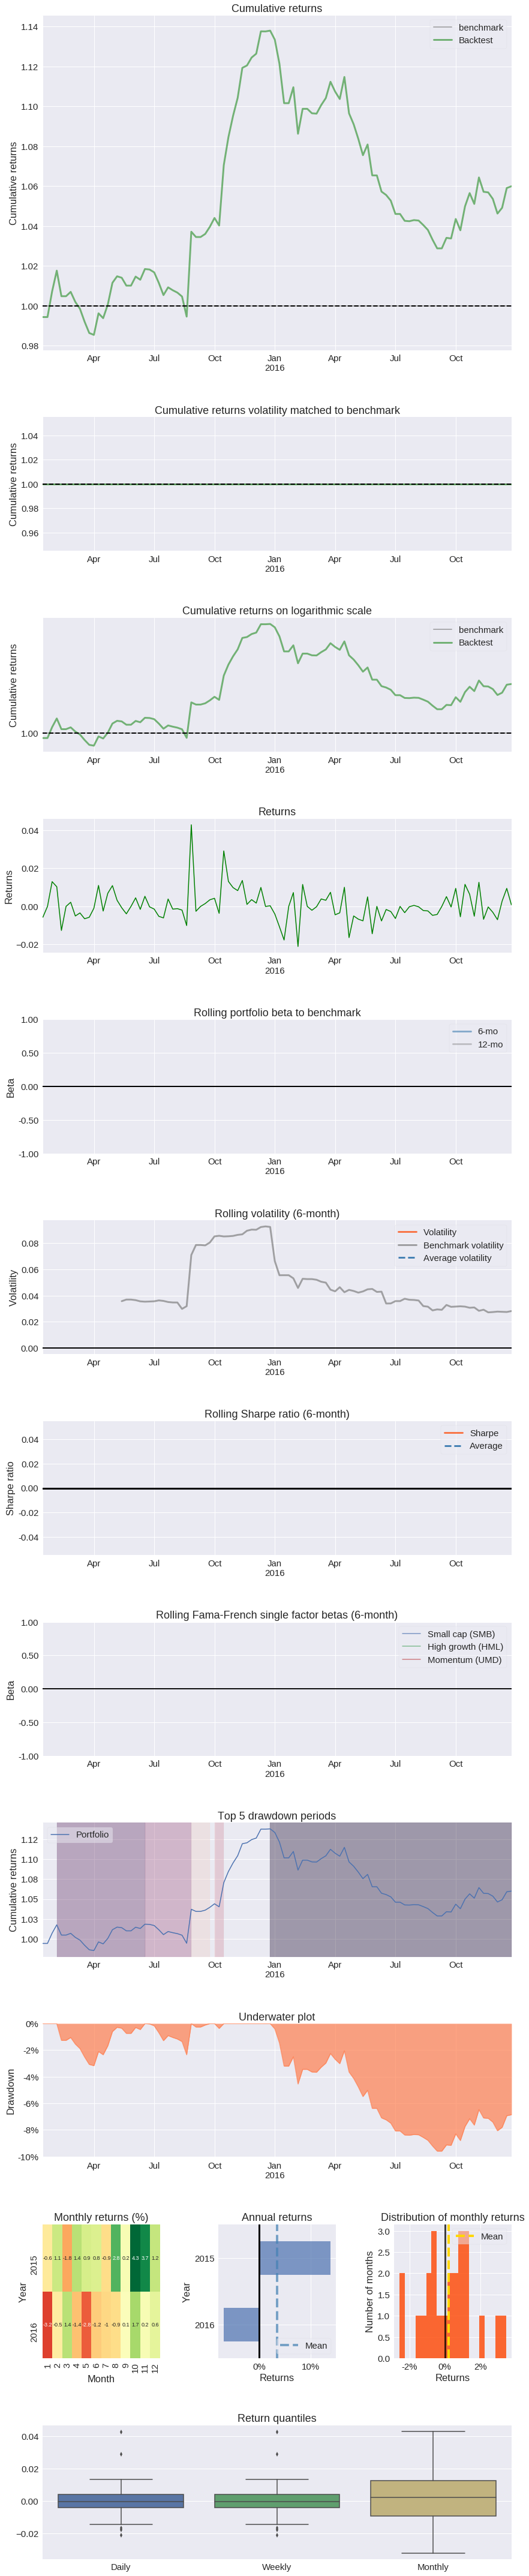

/home/lucasca/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Stress Events,mean,min,max
Fall2015,0.47%,-1.00%,4.28%
New Normal,0.06%,-2.10%,4.28%


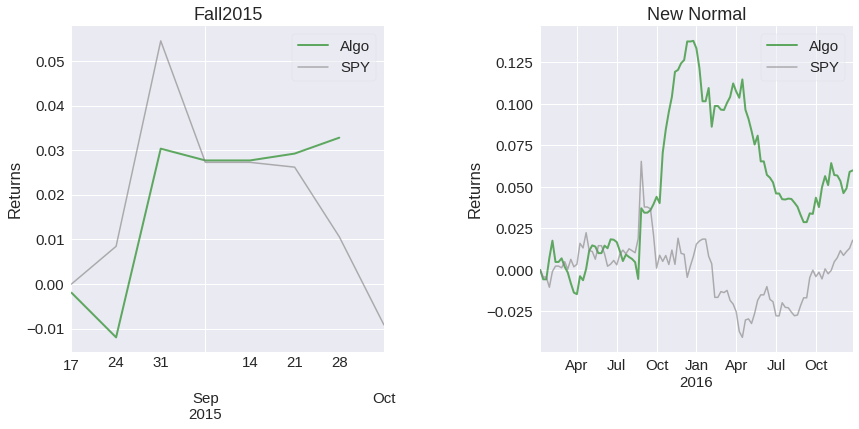

Top 10 long positions of all time,max
AAL,1.04%
AAPL,1.04%
ABBV,1.04%
ABC,1.04%
ACN,1.04%
ADI,1.04%
ADS,1.04%
AEE,1.04%
AES,1.04%
AET,1.04%


Top 10 short positions of all time,max
AAL,-1.04%
AAPL,-1.04%
ABBV,-1.04%
ABC,-1.04%
ABT,-1.04%
ADBE,-1.04%
ADI,-1.04%
AEE,-1.04%
AEP,-1.04%
AES,-1.04%


Top 10 positions of all time,max
AAL,1.04%
AAPL,1.04%
ABBV,1.04%
ABC,1.04%
ABT,1.04%
ACN,1.04%
ADBE,1.04%
ADI,1.04%
ADS,1.04%
AEE,1.04%


All positions ever held,max
XRAY,1.04%
JBHT,1.04%
ILMN,1.04%
INCY,1.04%
INFO,1.04%
INTC,1.04%
INTU,1.04%
IQV,1.04%
IR,1.04%
ISRG,1.04%


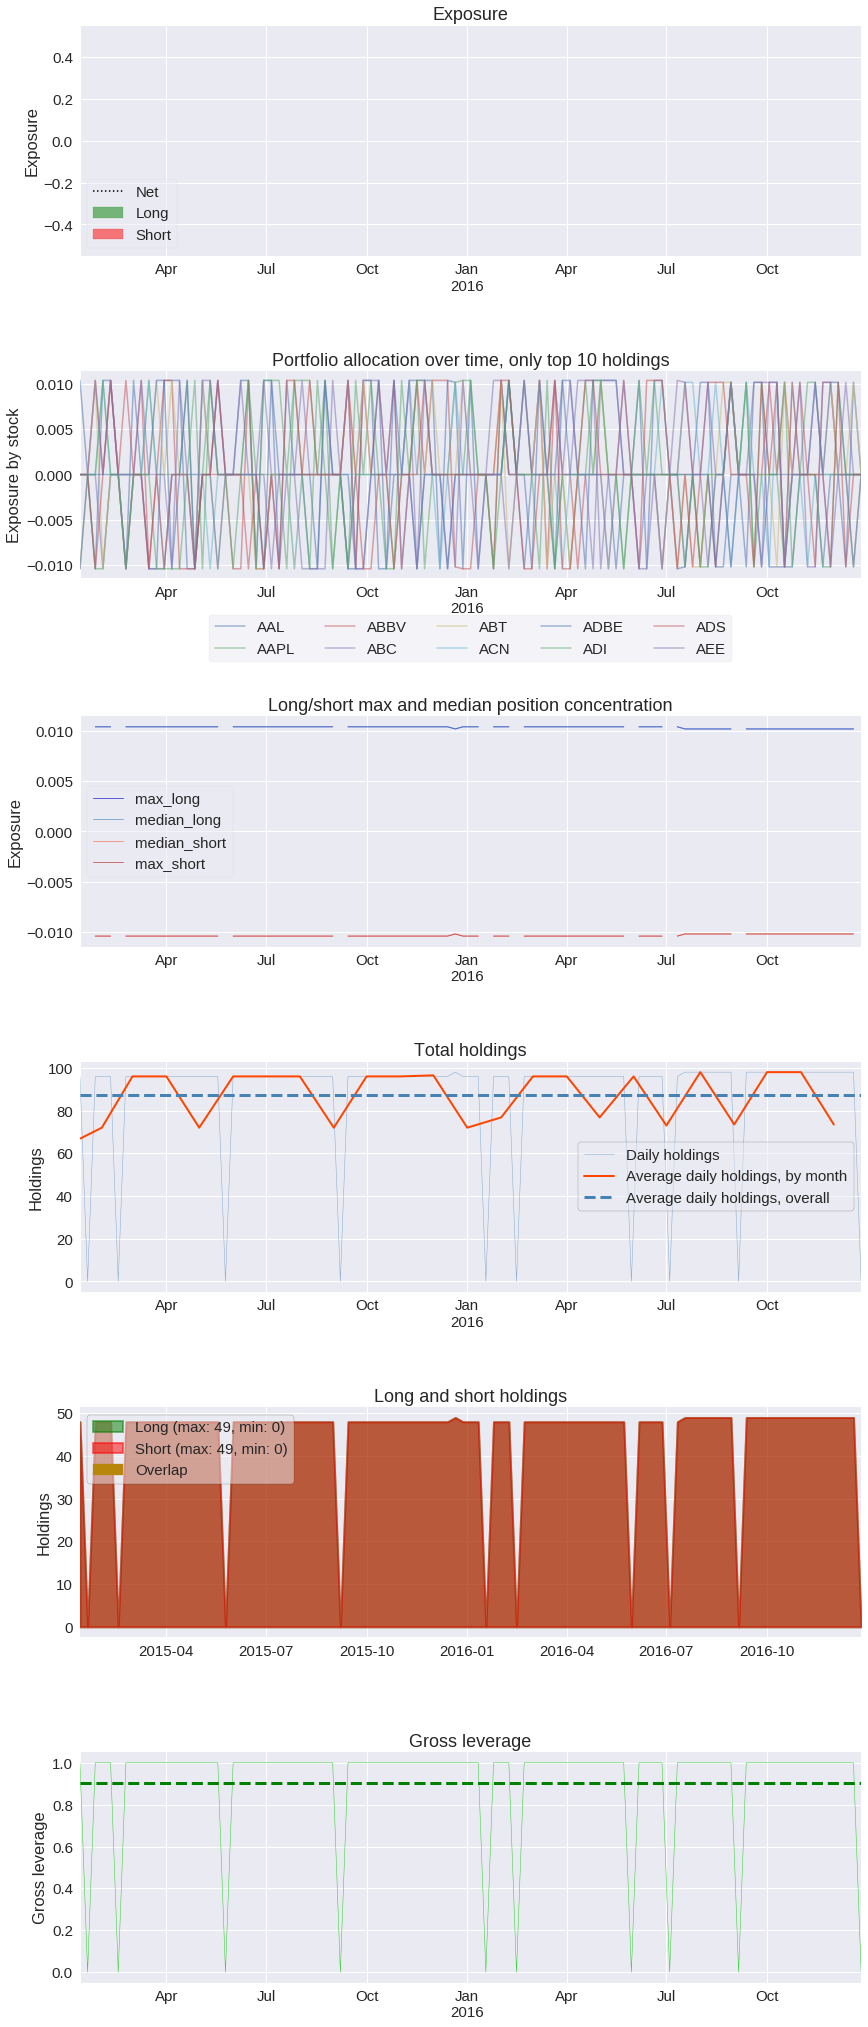

In [15]:
pyfolio.tears.create_full_tear_sheet(pf_returns,
                                     positions=pf_positions,
                                     benchmark_rets=pf_benchmark)

In [63]:
from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
# load the iris datasets
dataset = datasets.load_iris()
# fit an Extra Trees model to the data
model = RandomForestClassifier(n_estimators=1000)
model.fit(dataset.data, dataset.target)
# display the relative importance of each attribute
print(model.feature_importances_)

[ 0.09736969  0.02346273  0.44639873  0.43276885]


In [58]:
print(dataset.target)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [73]:
%matplotlib inline
import pandas as pd
import pyfolio as pf

In [74]:
stock_rets = pf.utils.get_symbol_rets('AAPL')

In [ ]:
stock_rets.plot()

ImportError: No module named plotting